In [3]:
import statistics
import pymysql as db_connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

connection = db_connector.connect(host='localhost',
                             user='your_user',
                             password='your_password',
                             db='vulinoss')

def execute_query_and_fetch_one(query):
    cursor = connection.cursor()
    cursor.execute(query)
    connection.commit()
    return cursor.fetchone()[0]


def fetch_code_metrics_for_version(version_id):
#     print("Fetching for project_id: {}".format(version_id))
    query = (
        "SELECT sum(cd.loc) as loc, sum(cd.testing_loc) as testing_loc "
        "FROM vulinoss.code_metrics as cd "
        "WHERE cd.prid = {} "
        "AND cd.language_id IN (10,11,13,17,18,21,"
        "24,25,33,43,61,65,66,67,72,79,87,88,89,"
        "91,92,102,123,124,129,132,133,144,149,"
        "155,160,167,178,196);"
    ).format(version_id)
    #print(query)
    cursor = connection.cursor()
    cursor.execute(query)
    connection.commit()
    results = cursor.fetchone()

    loc = 0
    if results[0]:
        loc = int(float(results[0]))
    testing_loc = 0
    if results[1]:
        testing_loc = int(float(results[1]))
    
    return loc, testing_loc


def fetch_nbc_loc(version_id):
    query = (
        "SELECT sum(loc) "
        "FROM vulinoss.code_metrics as cd "
        "WHERE cd.prid = {} "
        "AND cd.language_id IN (13,21,24,25); "
    ).format(version_id)
    cursor = connection.cursor()
    cursor.execute(query)
    connection.commit()
    results = cursor.fetchone()
    
    nbc_loc = 0
    if results[0]:
        nbc_loc = int(float(results[0]))
    
    return nbc_loc


def fetch_versions_for_project(project_id):
    query = (
        "SELECT pr.id, pr.version_name, vc.cve, pr.continuous_integration, cve.cvssV2_base_score "
        "FROM `vulinoss`.`vulnerable_cases` vc, "
        "`vulinoss`.`project_releases` pr, "
        "`vulinoss`.`project` as p, "
        "`vulinoss`.`cve` as cve "
        "WHERE p.id={} "
        "AND pr.pid=p.id "
        "AND vc.prid=pr.id "
        "AND pr.version_reference <>'' "
        "AND cve.id=vc.cve;"
    ).format(project_id)
    cursor = connection.cursor()
    cursor.execute(query)
    connection.commit()
    results = cursor.fetchall()
    cves_in_version = {}
    # retrieves the project_release_id, the version_name, all the CVES, the continuous iontegration and the cvssV2 base score
    version_id_to_version_name = {}
    version_id_to_ci = {}
    for entry in results:
        cve_with_severity = {}
        cve_with_severity[entry[2]] = entry[4]
        
        if entry[1] not in cves_in_version:
            cves_in_version[entry[1]] = [cve_with_severity]
        else:
            cves_in_version[entry[1]].append(cve_with_severity)
            
        version_id_to_version_name[entry[1]]=entry[0]
        version_id_to_ci[entry[1]]=entry[3]
        
    dataset = []
    for version in cves_in_version:
        dataset_entry = [version]
        number_of_vulnerabilities = len(cves_in_version[version]) # #cves
        # calculate the avg severity for this version
        severity_sum = 0
        for cve in cves_in_version[version]:
            severities = [] # used for caclulating the median
            for key in cve:
                severity_sum += cve[key]
                severities.append(cve[key])
        avg_severity = severity_sum/number_of_vulnerabilities
        media_severity = statistics.median(severities)
        # retrieve code metrics for this version
        loc, testing_loc = fetch_code_metrics_for_version(version_id_to_version_name[version])
        
        if loc == 0:
#             print("Check version {}".format(version_id_to_version_name[version]))
            continue
        vulnerability_density = (number_of_vulnerabilities/loc)*1000
        #exclude outliers
        if vulnerability_density > 2:
            continue
        testing_ratio = testing_loc/loc
        
        nbc_loc = fetch_nbc_loc(version_id_to_version_name[version])
        nbc_ratio = nbc_loc/loc
        ci=False
        if version_id_to_ci[version] is not None:
            ci = True
        
        
        dataset_entry.append(number_of_vulnerabilities)
        dataset_entry.append(vulnerability_density)  
        dataset_entry.append(avg_severity)
        dataset_entry.append(media_severity)
        dataset_entry.append(loc)
        dataset_entry.append(testing_loc)
        dataset_entry.append(testing_ratio)
        dataset_entry.append(nbc_loc)
        dataset_entry.append(nbc_ratio)
        dataset_entry.append(ci)
        dataset.append(dataset_entry)
        
    return dataset


def fetch_versions_for_all_projects():
    query = (
        "SELECT distinct p.id as project_id "
        "FROM vulinoss.project_releases as pr, "
        "vulinoss.project as p "
        "WHERE p.id=pr.pid "
        "AND pr.version_reference <>'';"
    )
    cursor = connection.cursor()
    cursor.execute(query)
    connection.commit()
    results = cursor.fetchall()
    dataset = []
    for entry in results:
        dataset += fetch_versions_for_project(entry[0])
    
    return dataset
  
    
dataset = fetch_versions_for_all_projects()
df = pd.DataFrame(dataset, columns = ["version","cves","cve_density","severity_avg","severity_median",
                                      "loc","testing_loc","testing_ratio","nbc_loc","nbc_ratio","ci"])

# Define and set the plot fonts values
MEDIUM_SIZE=18
SMALL_SIZE=15

plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

print(df[0:30])

       version  cves  cve_density  severity_avg  severity_median       loc  \
0       2.6.24   356     0.023484      5.344382              2.1  15159428   
1          4.8    19     0.001253      5.889474              4.6  15159428   
2         3.19    50     0.003298      6.726000              7.8  15159428   
3       2.6.11   473     0.031202      5.093446              2.1  15159428   
4       2.6.22   383     0.025265      5.370496              2.1  15159428   
5          3.7   229     0.015106      5.378166              7.8  15159428   
6         3.15    99     0.006531      5.878788              4.9  15159428   
7          4.2     1     0.000066      5.000000              5.0  15159428   
8   2.6.31-rc7     2     0.000132      4.950000              5.0  15159428   
9       2.6.26   315     0.020779      5.315238              2.1  15159428   
10      2.6.30   265     0.017481      5.206792              2.1  15159428   
11      2.6.17   396     0.026122      5.285101              2.1

# Vulnerability density to testing ratio

## Scatter plot including CI (red)

Dataset Size: 8387


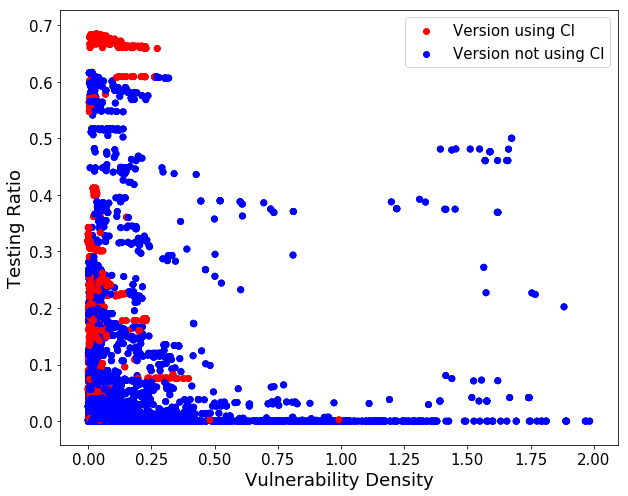

In [9]:
# create a dataframe as a subset of the main dataframe
subdf = df[['cve_density','testing_ratio','ci']]
#print(subdf[0:5])
print("Dataset Size: {}".format(len(subdf)))
# create the plot
plt.scatter(subdf['cve_density'], subdf['testing_ratio'],c=subdf['ci'],cmap='bwr')
# plt.title("Scatter plot of vulnearbility density and testing ratio")
plt.xlabel("Vulnerability Density")
plt.ylabel("Testing Ratio")
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = [10,8]
plt.legend(['Version using CI','Version not using CI'])
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('blue')
plt.show()

## Vulnerability density to testing ratio (Hexabin)

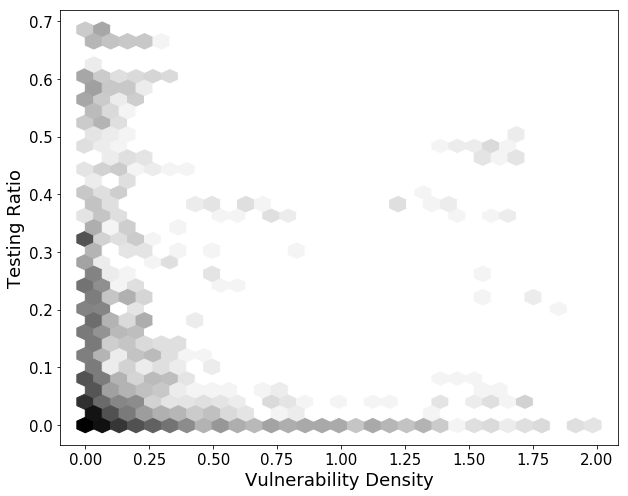

In [10]:
plt.hexbin(subdf['cve_density'], subdf['testing_ratio'], gridsize=30, bins='log', cmap='Greys')
plt.xlabel("Vulnerability Density")
plt.ylabel("Testing Ratio")
plt.rcParams["figure.figsize"] = [10,8]
plt.show()

# Vulnerability severity(avg) to testing ratio

Rows in dataset: 8387


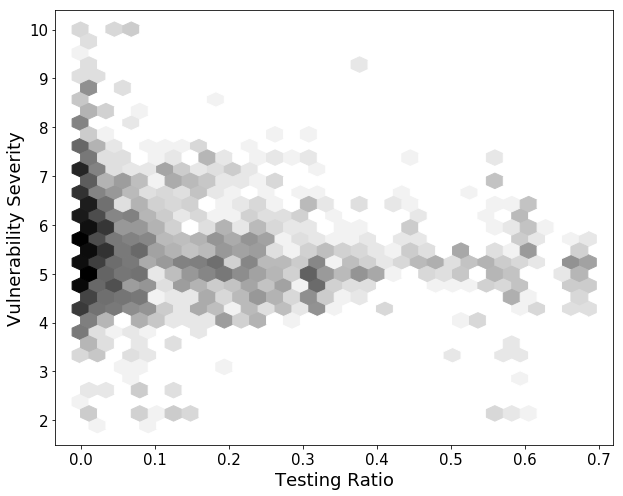

In [11]:
subdf = df[['severity_avg','testing_ratio']]
#print(subdf[0:5])
print("Rows in dataset: {}".format(len(subdf)))
# create the plot
plt.hexbin(subdf['testing_ratio'],subdf['severity_avg'], gridsize=30, bins='log', cmap='Greys')
plt.xlabel("Testing Ratio")
plt.ylabel("Vulnerability Severity")
plt.rcParams["figure.figsize"] = [10,8]
plt.show()

# Vulnerability severity to non-bound checking loc ratio

Rows in dataset: 8387


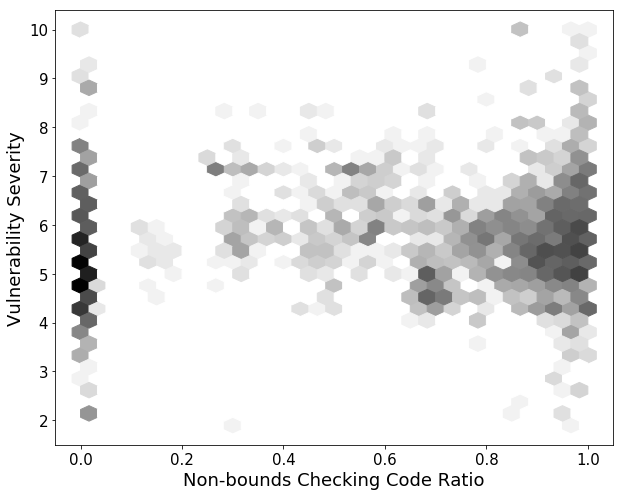

In [13]:
# create a dataframe as a subset of the main dataframe
subdf = df[['severity_avg','nbc_ratio']]
# print(subdf[0:5])
print("Rows in dataset: {}".format(len(subdf)))
# create the plot
plt.hexbin(subdf['nbc_ratio'],subdf['severity_avg'], gridsize=30,bins='log', cmap='Greys')
# plt.title("Scatter plot of vulnearbility severity [avg] and non bound checking code ratio")
plt.xlabel("Non-bounds Checking Code Ratio")
plt.ylabel("Vulnerability Severity")
plt.rcParams["figure.figsize"] = [10,8]
plt.show()